In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")


📦 Libraries imported successfully!


In [2]:
def get_latest_trained_models():
    """Find and return paths to the latest trained models."""
    model_dir = Path('../model')
    
    # Find all training directories
    training_dirs = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith('training_')]
    
    if not training_dirs:
        # Fallback to standard model locations
        print("⚠️  No training directories found, using standard model locations...")
        winner_model_path = '../model/ufc_random_forest_model_tuned.joblib'
        method_model_path = '../model/ufc_multiclass_model.joblib'
        winner_cols_path = '../model/winner_model_columns.json'
        method_cols_path = '../model/method_model_columns.json'
        fighters_data_path = '../model/ufc_fighters_engineered_corrected.csv'
        
        # Check if files exist
        if not Path(winner_model_path).exists():
            winner_model_path = '../model/ufc_random_forest_model.joblib'
        
        return winner_model_path, method_model_path, winner_cols_path, method_cols_path, fighters_data_path
    
    # Get the most recent training directory
    latest_training_dir = max(training_dirs, key=lambda x: x.stat().st_mtime)
    
    # Look for model files in the latest directory
    winner_models = list(latest_training_dir.glob('ufc_winner_model_*.joblib'))
    winner_tuned_models = list(latest_training_dir.glob('ufc_winner_model_tuned_*.joblib'))
    method_models = list(latest_training_dir.glob('ufc_method_model_*.joblib'))
    winner_cols_files = list(latest_training_dir.glob('winner_model_columns_*.json'))
    method_cols_files = list(latest_training_dir.glob('method_model_columns_*.json'))
    fighters_data_files = list(latest_training_dir.glob('ufc_fighters_engineered_*.csv'))
    
    # Prefer tuned models if available
    if winner_tuned_models:
        winner_model_path = str(max(winner_tuned_models, key=lambda x: x.stat().st_mtime))
    elif winner_models:
        winner_model_path = str(max(winner_models, key=lambda x: x.stat().st_mtime))
    else:
        winner_model_path = '../model/ufc_random_forest_model_tuned.joblib'
    
    method_model_path = str(max(method_models, key=lambda x: x.stat().st_mtime)) if method_models else '../model/ufc_multiclass_model.joblib'
    winner_cols_path = str(max(winner_cols_files, key=lambda x: x.stat().st_mtime)) if winner_cols_files else '../model/winner_model_columns.json'
    method_cols_path = str(max(method_cols_files, key=lambda x: x.stat().st_mtime)) if method_cols_files else '../model/method_model_columns.json'
    fighters_data_path = str(max(fighters_data_files, key=lambda x: x.stat().st_mtime)) if fighters_data_files else '../model/ufc_fighters_engineered_corrected.csv'
    
    print(f"📁 Using latest trained models from: {latest_training_dir.name}")
    print(f"   Winner model: {Path(winner_model_path).name}")
    print(f"   Method model: {Path(method_model_path).name}")
    
    return winner_model_path, method_model_path, winner_cols_path, method_cols_path, fighters_data_path

# Auto-load latest models
print("🔍 Auto-detecting latest trained models...")
winner_model_path, method_model_path, winner_cols_path, method_cols_path, fighters_data_path = get_latest_trained_models()


🔍 Auto-detecting latest trained models...
📁 Using latest trained models from: training_2025-06-23_22-38
   Winner model: ufc_winner_model_tuned_2025-06-23_22-38.joblib
   Method model: ufc_method_model_2025-06-23_22-38.joblib


In [3]:
# Load models and data
print("📖 Loading models and data...")

try:
    # Load models
    winner_model = joblib.load(winner_model_path)
    method_model = joblib.load(method_model_path)
    
    # Load feature columns
    with open(winner_cols_path, 'r') as f:
        winner_cols = json.load(f)
    with open(method_cols_path, 'r') as f:
        method_cols = json.load(f)
        
    # Load fighter data
    fighters_df = pd.read_csv(fighters_data_path)
    
    print(f"✅ Successfully loaded:")
    print(f"   Winner model: {winner_model.__class__.__name__} with {len(winner_cols)} features")
    print(f"   Method model: {method_model.__class__.__name__} with {len(method_cols)} features")
    print(f"   Fighter database: {len(fighters_df):,} fighters")
    print(f"   Available classes: {list(method_model.classes_)}")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("Please run training first: python main.py --mode pipeline --tune")


📖 Loading models and data...
✅ Successfully loaded:
   Winner model: RandomForestClassifier with 64 features
   Method model: RandomForestClassifier with 64 features
   Fighter database: 4,374 fighters
   Available classes: ['Decision', 'KO/TKO', 'Submission']


In [4]:
def _get_full_prediction_from_perspective(fighter1_name, fighter2_name, all_fighters_data, win_cols, meth_cols, win_model, meth_model):
    """Calculate prediction from a specific perspective (fighter1 as blue corner)."""
    # Normalize fighter names for lookup
    def normalize_name(name):
        return name.strip().lower()
    
    # Find fighters in database
    fighter1_normalized = normalize_name(fighter1_name)
    fighter2_normalized = normalize_name(fighter2_name)
    
    all_fighters_data['Name_normalized'] = all_fighters_data['Name'].str.strip().str.lower()
    
    fighter1_data = all_fighters_data[all_fighters_data['Name_normalized'] == fighter1_normalized]
    fighter2_data = all_fighters_data[all_fighters_data['Name_normalized'] == fighter2_normalized]
    
    if fighter1_data.empty:
        return {"error": f"Fighter '{fighter1_name}' not found in database"}, None
    if fighter2_data.empty:
        return {"error": f"Fighter '{fighter2_name}' not found in database"}, None
    
    # Get fighter stats
    blue_stats = {f"blue_{col}": fighter1_data.iloc[0][col] for col in fighter1_data.columns if col not in ['Name', 'Name_normalized']}
    red_stats = {f"red_{col}": fighter2_data.iloc[0][col] for col in fighter2_data.columns if col not in ['Name', 'Name_normalized']}
    
    # Calculate differential features
    diff_features = {}
    for blue_col, red_col in zip(blue_stats.keys(), red_stats.keys()):
        if blue_col.replace('blue_', '') == red_col.replace('red_', ''):
            base_name = blue_col.replace('blue_', '')
            if isinstance(blue_stats[blue_col], (int, float)) and isinstance(red_stats[red_col], (int, float)):
                diff_col_name = base_name.lower().replace(' ', '_').replace('.', '') + '_diff'
                diff_features[diff_col_name] = blue_stats[blue_col] - red_stats[red_col]
    
    single_fight_data = {**blue_stats, **red_stats, **diff_features}
    prediction_df_base = pd.DataFrame([single_fight_data])

    X_winner = prediction_df_base.reindex(columns=win_cols, fill_value=0)
    winner_probs = win_model.predict_proba(X_winner)[0]

    X_method = prediction_df_base.reindex(columns=meth_cols, fill_value=0)
    method_probs = meth_model.predict_proba(X_method)[0]
    
    return winner_probs, method_probs

def predict_fight_symmetrical(fighter_a, fighter_b, all_fighters_data, win_cols, meth_cols, win_model, meth_model):
    """Calculate a final, symmetrical prediction for both winner and method."""
    # Prediction 1: A is in the blue corner
    winner_probs1, method_probs1 = _get_full_prediction_from_perspective(fighter_a, fighter_b, all_fighters_data, win_cols, meth_cols, win_model, meth_model)
    if isinstance(winner_probs1, dict) and "error" in winner_probs1:
        return winner_probs1

    # Prediction 2: B is in the blue corner
    winner_probs2, method_probs2 = _get_full_prediction_from_perspective(fighter_b, fighter_a, all_fighters_data, win_cols, meth_cols, win_model, meth_model)
    if isinstance(winner_probs2, dict) and "error" in winner_probs2:
        return winner_probs2

    # Average the winner probabilities
    prob_a_wins_as_blue = winner_probs1[1]  # P(A wins | A is blue)
    prob_a_wins_as_red = 1 - winner_probs2[1] # P(A wins | A is red) = 1 - P(B wins | B is blue)
    final_prob_a_wins = (prob_a_wins_as_blue + prob_a_wins_as_red) / 2
    final_prob_b_wins = 1 - final_prob_a_wins
    
    # Average the method probabilities
    avg_method_probs = (method_probs1 + method_probs2) / 2
    method_classes = meth_model.classes_
    predicted_method = method_classes[np.argmax(avg_method_probs)]

    # Format the final result
    result = {
        "matchup": f"{fighter_a} vs. {fighter_b}",
        "predicted_winner": fighter_a if final_prob_a_wins > final_prob_b_wins else fighter_b,
        "winner_confidence": f"{max(final_prob_a_wins, final_prob_b_wins)*100:.2f}%",
        "win_probabilities": {
            fighter_a: f"{final_prob_a_wins*100:.2f}%",
            fighter_b: f"{final_prob_b_wins*100:.2f}%",
        },
        "predicted_method": predicted_method,
        "method_probabilities": {
            method_classes[i]: f"{avg_method_probs[i]*100:.2f}%" for i in range(len(method_classes))
        },
        "raw_winner_probs": [final_prob_a_wins, final_prob_b_wins],
        "raw_method_probs": avg_method_probs
    }
    return result

print("🎯 Prediction functions loaded successfully!")


🎯 Prediction functions loaded successfully!


In [5]:
def predict_single_fight(fighter1, fighter2, show_plot=True):
    """Predict a single fight with optional visualization."""
    print(f"🥊 Predicting: {fighter1} vs {fighter2}")
    print("="*50)
    
    result = predict_fight_symmetrical(
        fighter1, fighter2, fighters_df, 
        winner_cols, method_cols, winner_model, method_model
    )
    
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
        
        # Show similar fighter names
        available_fighters = fighters_df['Name'].tolist()
        similar1 = [f for f in available_fighters if fighter1.lower() in f.lower()][:5]
        similar2 = [f for f in available_fighters if fighter2.lower() in f.lower()][:5]
        
        if similar1:
            print(f"Similar to '{fighter1}': {', '.join(similar1)}")
        if similar2:
            print(f"Similar to '{fighter2}': {', '.join(similar2)}")
        return None
    
    # Display results
    print(f"🏆 Predicted Winner: {result['predicted_winner']} ({result['winner_confidence']})")
    print(f"⚔️  Predicted Method: {result['predicted_method']}")
    
    print(f"\n📊 Win Probabilities:")
    for fighter, prob in result['win_probabilities'].items():
        print(f"   {fighter}: {prob}")
    
    print(f"\n🥊 Method Probabilities:")
    for method, prob in result['method_probabilities'].items():
        print(f"   {method}: {prob}")
    
    # Create visualization
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Winner probability pie chart
        fighters = list(result['win_probabilities'].keys())
        win_probs = [float(p.replace('%', '')) for p in result['win_probabilities'].values()]
        colors = ['#FF6B6B', '#4ECDC4']
        
        wedges, texts, autotexts = ax1.pie(win_probs, labels=fighters, autopct='%1.1f%%', 
                                          colors=colors, startangle=90, textprops={'fontsize': 12})
        ax1.set_title(f'Winner Prediction\n{result["predicted_winner"]} Wins', fontsize=14, fontweight='bold')
        
        # Method probability bar chart
        methods = list(result['method_probabilities'].keys())
        method_probs = [float(p.replace('%', '')) for p in result['method_probabilities'].values()]
        
        bars = ax2.bar(methods, method_probs, color=['#FFD93D', '#FF6B6B', '#6BCF7F'])
        ax2.set_title(f'Method Prediction\n{result["predicted_method"]}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Probability (%)', fontsize=12)
        ax2.set_ylim(0, 100)
        
        # Add value labels on bars
        for bar, prob in zip(bars, method_probs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return result

print("📈 Visualization functions ready!")


📈 Visualization functions ready!


In [6]:
def predict_multiple_fights(fight_list, show_summary=True):
    """Predict multiple fights and show summary statistics."""
    results = {
        "event_summary": {
            "total_fights": len(fight_list),
            "processed_fights": 0,
            "failed_fights": 0,
            "prediction_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        "fight_predictions": [],
        "failed_predictions": [],
        "method_distribution": {"Decision": 0, "KO/TKO": 0, "Submission": 0}
    }
    
    print(f"🃏 Predicting {len(fight_list)} fights...")
    print("="*60)
    
    for i, fight_string in enumerate(fight_list, 1):
        if " vs " in fight_string:
            fighter_a, fighter_b = fight_string.split(" vs ")
            fighter_a, fighter_b = fighter_a.strip(), fighter_b.strip()
        elif " vs. " in fight_string:
            fighter_a, fighter_b = fight_string.split(" vs. ")
            fighter_a, fighter_b = fighter_a.strip(), fighter_b.strip()
        else:
            print(f"❌ Fight {i}: Invalid format '{fight_string}'")
            results["failed_predictions"].append({
                "fight": fight_string,
                "error": "Invalid format - use 'Fighter A vs Fighter B'"
            })
            results["event_summary"]["failed_fights"] += 1
            continue
        
        print(f"Fight {i}: {fighter_a} vs {fighter_b}")
        
        prediction = predict_fight_symmetrical(
            fighter_a, fighter_b, fighters_df,
            winner_cols, method_cols, winner_model, method_model
        )
        
        if 'error' in prediction:
            print(f"  ❌ {prediction['error']}")
            results["failed_predictions"].append({
                "fight": fight_string,
                "error": prediction['error']
            })
            results["event_summary"]["failed_fights"] += 1
        else:
            print(f"  🏆 Winner: {prediction['predicted_winner']} ({prediction['winner_confidence']})")
            print(f"  ⚔️  Method: {prediction['predicted_method']}")
            
            results["fight_predictions"].append(prediction)
            results["method_distribution"][prediction['predicted_method']] += 1
            results["event_summary"]["processed_fights"] += 1
        
        print()
    
    # Display summary
    if show_summary and results["fight_predictions"]:
        print("📊 EVENT SUMMARY")
        print("="*40)
        print(f"Total Fights: {results['event_summary']['total_fights']}")
        print(f"Successful Predictions: {results['event_summary']['processed_fights']}")
        print(f"Failed Predictions: {results['event_summary']['failed_fights']}")
        print(f"Success Rate: {(results['event_summary']['processed_fights']/results['event_summary']['total_fights'])*100:.1f}%")
        
        print(f"\n🥊 METHOD BREAKDOWN:")
        for method, count in results["method_distribution"].items():
            if count > 0:
                percentage = (count / results['event_summary']['processed_fights']) * 100
                print(f"  {method}: {count} fights ({percentage:.1f}%)")
        
        # Create method distribution chart
        methods = [k for k, v in results["method_distribution"].items() if v > 0]
        counts = [v for v in results["method_distribution"].values() if v > 0]
        
        if methods:
            plt.figure(figsize=(10, 6))
            colors = ['#FFD93D', '#FF6B6B', '#6BCF7F']
            bars = plt.bar(methods, counts, color=colors[:len(methods)])
            plt.title('Predicted Fight Methods Distribution', fontsize=14, fontweight='bold')
            plt.ylabel('Number of Fights', fontsize=12)
            
            # Add value labels
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        str(count), ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
    
    return results

print("🃏 Multi-fight prediction functions ready!")


🃏 Multi-fight prediction functions ready!


🥊 Predicting: Jon Jones vs Stipe Miocic
🏆 Predicted Winner: Jon Jones (75.23%)
⚔️  Predicted Method: KO/TKO

📊 Win Probabilities:
   Jon Jones: 75.23%
   Stipe Miocic: 24.77%

🥊 Method Probabilities:
   Decision: 3.21%
   KO/TKO: 68.62%
   Submission: 28.17%


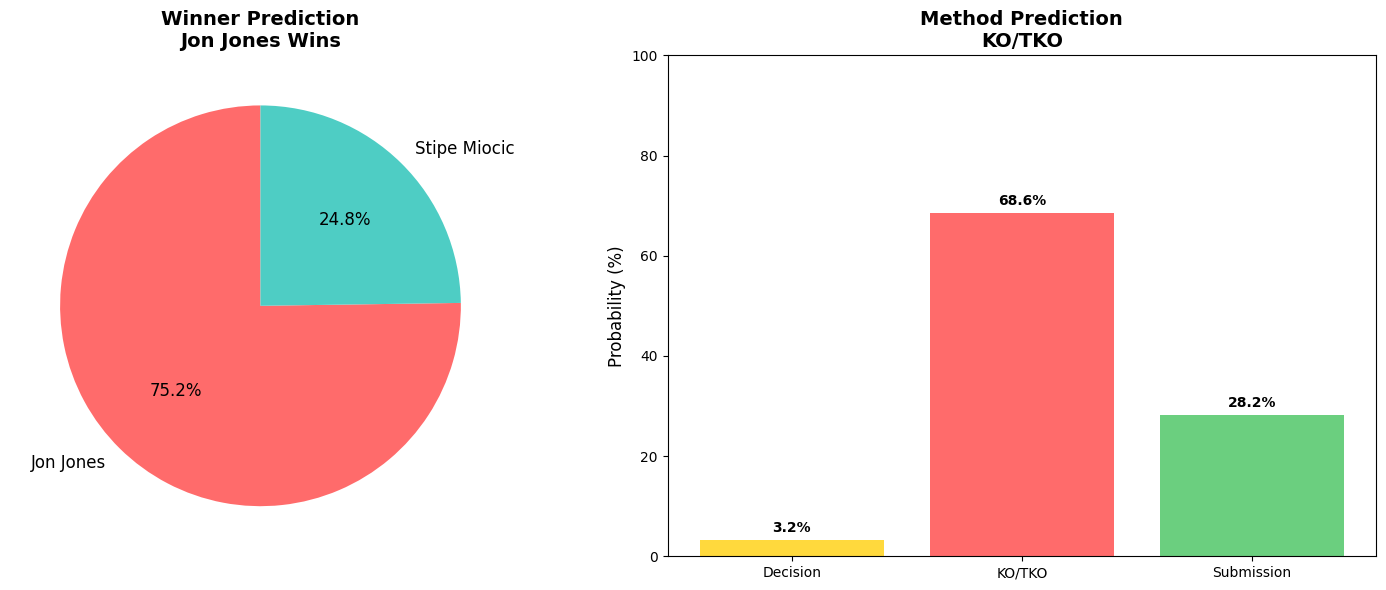

In [7]:
# Example: Single fight prediction
fighter1 = "Jon Jones"
fighter2 = "Stipe Miocic"

prediction = predict_single_fight(fighter1, fighter2, show_plot=True)


🃏 Predicting 12 fights...
Fight 1: Jamahal Hill vs Khalil Rountree Jr.
  🏆 Winner: Khalil Rountree Jr. (55.91%)
  ⚔️  Method: KO/TKO

Fight 2: Rafael Fiziev vs Ignacio Bahamondes
  🏆 Winner: Rafael Fiziev (58.08%)
  ⚔️  Method: KO/TKO

Fight 3: Curtis Blaydes vs Rizvan Kuniev
  🏆 Winner: Curtis Blaydes (57.18%)
  ⚔️  Method: KO/TKO

Fight 4: Tofiq Musayev vs Myktybek Orolbai
  🏆 Winner: Myktybek Orolbai (88.04%)
  ⚔️  Method: Submission

Fight 5: Nazim Sadykhov vs Nikolas Motta
  🏆 Winner: Nazim Sadykhov (77.60%)
  ⚔️  Method: KO/TKO

Fight 6: Muhammad Naimov vs Bogdan Grad
  🏆 Winner: Muhammad Naimov (56.91%)
  ⚔️  Method: KO/TKO

Fight 7: Seokhyeon Ko vs Oban Elliott
  🏆 Winner: Seokhyeon Ko (70.03%)
  ⚔️  Method: KO/TKO

Fight 8: Ismail Naurdiev vs JunYong Park
  🏆 Winner: JunYong Park (54.76%)
  ⚔️  Method: KO/TKO

Fight 9: Daria Zhelezniakova vs Melissa Mullins
  🏆 Winner: Daria Zhelezniakova (59.79%)
  ⚔️  Method: KO/TKO

Fight 10: Irina Alekseeva vs Klaudia Sygula
  🏆 Winner: Kl

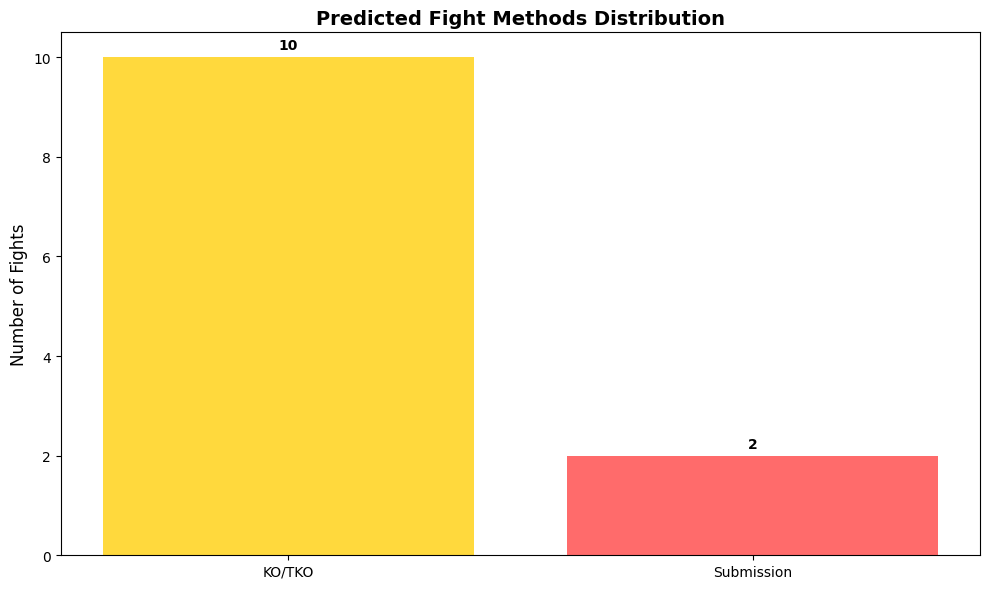

In [8]:
# Example: Full UFC card predictions
ufc_card = [
    "Jamahal Hill vs. Khalil Rountree Jr.",
    "Rafael Fiziev vs. Ignacio Bahamondes",
    "Curtis Blaydes vs. Rizvan Kuniev",
    "Tofiq Musayev vs. Myktybek Orolbai",
    "Nazim Sadykhov vs. Nikolas Motta",
    "Muhammad Naimov vs. Bogdan Grad",
    "Seokhyeon Ko vs. Oban Elliott",
    "Ismail Naurdiev vs. JunYong Park",
    "Daria Zhelezniakova vs. Melissa Mullins",
    "Irina Alekseeva vs. Klaudia Sygula",
    "Tagir Ulanbekov vs. Azat Maksum",
    "Hamdy Abdelwahab vs. Mohammed Usman"
]

card_results = predict_multiple_fights(ufc_card, show_summary=True)


In [9]:
def search_fighters(search_term, limit=10):
    """Search for fighters by name."""
    search_term_lower = search_term.lower()
    matches = fighters_df[fighters_df['Name'].str.lower().str.contains(search_term_lower, na=False)]
    
    if matches.empty:
        print(f"No fighters found matching '{search_term}'")
        return []
    
    fighter_names = matches['Name'].head(limit).tolist()
    print(f"Found {len(matches)} fighters matching '{search_term}':")
    for i, name in enumerate(fighter_names, 1):
        print(f"{i:2d}. {name}")
    
    if len(matches) > limit:
        print(f"... and {len(matches) - limit} more")
    
    return fighter_names

# Example: Search for fighters
print("🔍 Search example:")
search_fighters("Jones", limit=5)


🔍 Search example:
Found 21 fighters matching 'Jones':
 1. Victor Jones
 2. Jesse Jones
 3. Roy Jones
 4. Craig Jones
 5. Paul Jones
... and 16 more


['Victor Jones', 'Jesse Jones', 'Roy Jones', 'Craig Jones', 'Paul Jones']

In [10]:
def get_model_info():
    """Display information about the loaded models."""
    print("🤖 MODEL INFORMATION")
    print("="*50)
    
    print(f"Winner Model: {winner_model.__class__.__name__}")
    if hasattr(winner_model, 'n_estimators'):
        print(f"  - Trees: {winner_model.n_estimators}")
    if hasattr(winner_model, 'max_depth'):
        print(f"  - Max Depth: {winner_model.max_depth}")
    print(f"  - Features: {len(winner_cols)}")
    
    print(f"\nMethod Model: {method_model.__class__.__name__}")
    if hasattr(method_model, 'n_estimators'):
        print(f"  - Trees: {method_model.n_estimators}")
    if hasattr(method_model, 'max_depth'):
        print(f"  - Max Depth: {method_model.max_depth}")
    print(f"  - Features: {len(method_cols)}")
    print(f"  - Classes: {list(method_model.classes_)}")
    
    print(f"\nFighter Database: {len(fighters_df):,} fighters")
    print(f"Model Paths:")
    print(f"  - Winner: {Path(winner_model_path).name}")
    print(f"  - Method: {Path(method_model_path).name}")

# Display model information
get_model_info()


🤖 MODEL INFORMATION
Winner Model: RandomForestClassifier
  - Trees: 300
  - Max Depth: 40
  - Features: 64

Method Model: RandomForestClassifier
  - Trees: 200
  - Max Depth: None
  - Features: 64
  - Classes: ['Decision', 'KO/TKO', 'Submission']

Fighter Database: 4,374 fighters
Model Paths:
  - Winner: ufc_winner_model_tuned_2025-06-23_22-38.joblib
  - Method: ufc_method_model_2025-06-23_22-38.joblib


🥊 Predicting: Conor McGregor vs Khabib Nurmagomedov
🏆 Predicted Winner: Khabib Nurmagomedov (70.92%)
⚔️  Predicted Method: KO/TKO

📊 Win Probabilities:
   Conor McGregor: 29.08%
   Khabib Nurmagomedov: 70.92%

🥊 Method Probabilities:
   Decision: 5.52%
   KO/TKO: 55.96%
   Submission: 38.52%


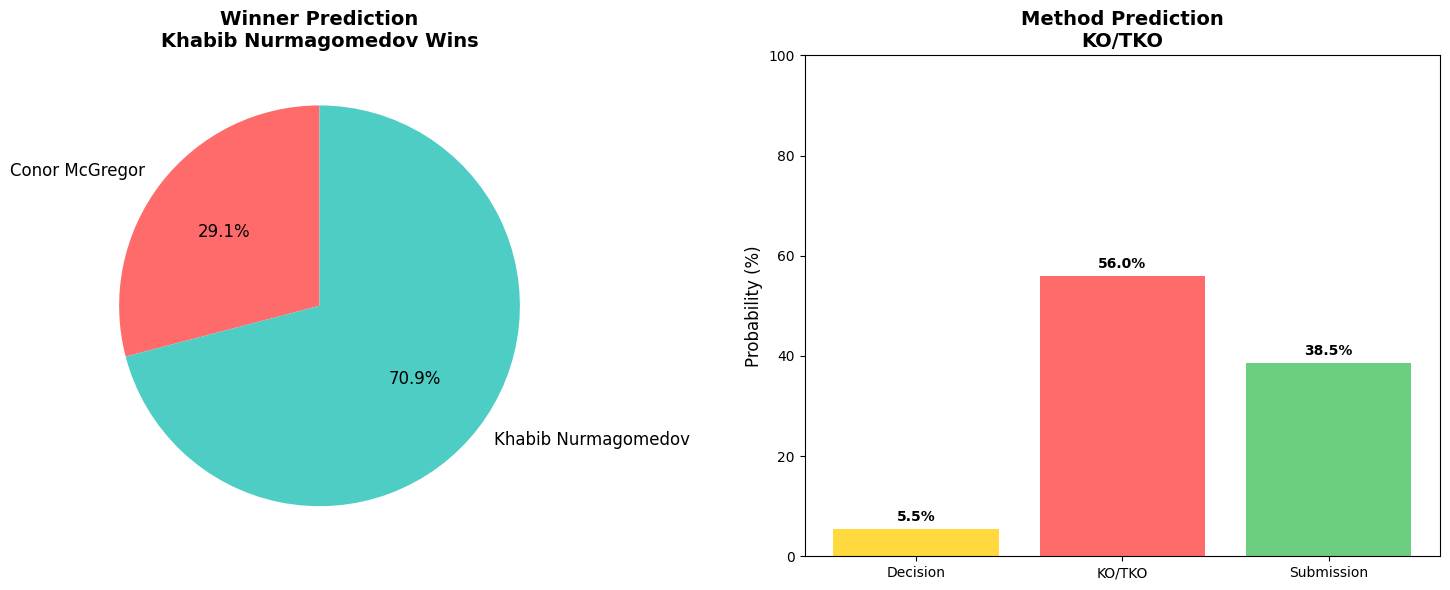

In [11]:
# YOUR CUSTOM PREDICTIONS HERE
# Modify these fighter names to predict any matchup

my_fighter1 = "Conor McGregor"
my_fighter2 = "Khabib Nurmagomedov"

my_prediction = predict_single_fight(my_fighter1, my_fighter2, show_plot=True)


In [12]:
# YOUR CUSTOM CARD PREDICTIONS HERE
# Add your own list of fights to predict

my_custom_card = [
    "Fighter A vs Fighter B",
    "Fighter C vs Fighter D",
    # Add more fights here...
]

# Uncomment the line below to run predictions
# my_card_results = predict_multiple_fights(my_custom_card, show_summary=True)
